<a href="https://colab.research.google.com/github/yashb98/90Days_Machine_learinng/blob/main/Computer_vision_CNN_Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import struct
import copy


## Data Loading

In [2]:
# Helper functions to read IDX files
def read_idx_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, 1, rows, cols)
        return torch.tensor(data, dtype=torch.float32)

def read_idx_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return torch.tensor(data, dtype=torch.long)

# Load your provided dataset files
train_images = read_idx_images('/content/train-images.idx3-ubyte')
train_labels = read_idx_labels('/content/train-labels.idx1-ubyte')
test_images = read_idx_images('/content/t10k-images.idx3-ubyte')
test_labels = read_idx_labels('/content/t10k-labels.idx1-ubyte')

print(f"Loaded Train: {train_images.shape}, Test: {test_images.shape}")

Loaded Train: torch.Size([60000, 1, 28, 28]), Test: torch.Size([10000, 1, 28, 28])


This code loads MNIST-style IDX files:

	•	read_idx_images reads image files, reshapes them to (num, 1, rows, cols), and converts to float tensors.
	•	read_idx_labels reads label files and converts them to long tensors.
	•	Finally, it loads train and test images/labels and prints their shapes.


##  Create a Custom PyTorch Dataset

We’ll wrap the loaded tensors into a torch.utils.data.Dataset to enable batching, shuffling, and easy DataLoader use.

In [3]:
class FashionMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define transformations
transform = transforms.Normalize((0.5,), (0.5,))

# Create dataset objects
full_train_dataset = FashionMNISTDataset(train_images / 255.0, train_labels, transform)
test_dataset = FashionMNISTDataset(test_images / 255.0, test_labels, transform)

This code defines a custom PyTorch dataset for FashionMNIST:

	•	FashionMNISTDataset stores images and labels and supports optional transformations.
	•	__len__ returns the dataset size; __getitem__ retrieves an image-label pair.
	•	Images are normalized to [0,1] then standardized with mean 0.5 and std 0.5.
	•	full_train_dataset and test_dataset are created for training and testing.

## Create Training, Validation, and Test DataLoaders

We’ll split the training set into 80% training and 20% validation, then prepare DataLoaders with mini-batch processing.



In [4]:
# Split into train/validation
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

✅ Train: 48000, Val: 12000, Test: 10000


This code prepares data for training:

	•	Splits the full training dataset into 80% train and 20% validation.
	•	Creates DataLoaders for train, validation, and test sets with a batch size of 64.
	•	Training loader is shuffled; validation and test loaders are not.

## Define the CNN Model

Our CNN includes:

	•	2 convolutional + pooling layers
	•	Batch normalization
	•	Dropout
	•	2 fully connected layers

In [5]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = FashionCNN()
print(model)

FashionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


## Define Device, Loss Function, Optimizer & Scheduler

We’ll use:

	•	Device: GPU if available
	•	Optimizer: SGD with momentum
	•	Scheduler: StepLR to reduce LR every 10 epochs
	•	Loss: CrossEntropyLoss

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

 Using device: cuda


## Early Stopping Implementation

Stops training if validation loss does not improve for several epochs.

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_state)

early_stopping = EarlyStopping(patience=5)

This code implements early stopping for training:

	•	Monitors validation loss and stops training if it doesn’t improve for patience epochs.
	•	Saves the best model weights when improvement occurs.
	•	restore_best_weights restores the model to the best-performing state.

## Train the CNN with Early Stopping and Scheduler

We train the CNN for up to 30 epochs.
Training and validation accuracy/loss are tracked each epoch.
Learning rate is automatically reduced using StepLR.

In [8]:
num_epochs = 30
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Restoring best model weights...")
        early_stopping.restore_best_weights(model)
        break

Epoch 1/30 [Training]: 100%|██████████| 750/750 [00:06<00:00, 112.93it/s]


Epoch 1: Train Loss=0.1789, Val Loss=0.0548, Train Acc=94.38%, Val Acc=98.25%


Epoch 2/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 128.40it/s]


Epoch 2: Train Loss=0.0622, Val Loss=0.0391, Train Acc=98.11%, Val Acc=98.84%


Epoch 3/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 142.36it/s]


Epoch 3: Train Loss=0.0468, Val Loss=0.0380, Train Acc=98.55%, Val Acc=98.95%


Epoch 4/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 129.82it/s]


Epoch 4: Train Loss=0.0385, Val Loss=0.0403, Train Acc=98.82%, Val Acc=98.81%


Epoch 5/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 142.77it/s]


Epoch 5: Train Loss=0.0317, Val Loss=0.0356, Train Acc=99.01%, Val Acc=99.02%


Epoch 6/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 129.87it/s]


Epoch 6: Train Loss=0.0272, Val Loss=0.0414, Train Acc=99.16%, Val Acc=98.97%


Epoch 7/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 141.95it/s]


Epoch 7: Train Loss=0.0212, Val Loss=0.0320, Train Acc=99.32%, Val Acc=99.14%


Epoch 8/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 129.73it/s]


Epoch 8: Train Loss=0.0189, Val Loss=0.0312, Train Acc=99.38%, Val Acc=99.19%


Epoch 9/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 142.18it/s]


Epoch 9: Train Loss=0.0172, Val Loss=0.0324, Train Acc=99.45%, Val Acc=99.16%


Epoch 10/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 127.99it/s]


Epoch 10: Train Loss=0.0141, Val Loss=0.0363, Train Acc=99.53%, Val Acc=99.04%


Epoch 11/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 140.01it/s]


Epoch 11: Train Loss=0.0085, Val Loss=0.0311, Train Acc=99.76%, Val Acc=99.19%


Epoch 12/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 133.72it/s]


Epoch 12: Train Loss=0.0064, Val Loss=0.0308, Train Acc=99.82%, Val Acc=99.28%


Epoch 13/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 136.14it/s]


Epoch 13: Train Loss=0.0060, Val Loss=0.0308, Train Acc=99.82%, Val Acc=99.26%


Epoch 14/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 140.87it/s]


Epoch 14: Train Loss=0.0057, Val Loss=0.0310, Train Acc=99.86%, Val Acc=99.27%


Epoch 15/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 128.16it/s]


Epoch 15: Train Loss=0.0056, Val Loss=0.0309, Train Acc=99.84%, Val Acc=99.25%


Epoch 16/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 141.12it/s]


Epoch 16: Train Loss=0.0051, Val Loss=0.0312, Train Acc=99.87%, Val Acc=99.28%


Epoch 17/30 [Training]: 100%|██████████| 750/750 [00:05<00:00, 129.62it/s]


Epoch 17: Train Loss=0.0047, Val Loss=0.0309, Train Acc=99.87%, Val Acc=99.32%
Early stopping triggered. Restoring best model weights...


This code trains a PyTorch model with validation and early stopping:

	•	Loops for num_epochs, performing training on train_loader and validation on val_loader.
	•	Tracks loss and accuracy for both train and validation sets.
	•	Updates learning rate via scheduler.step().
	•	Uses early stopping to halt training if validation loss stops improving and restores the best model.

## Evaluate the Model on Test Set

In [9]:
model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_acc:.2f}%")

Final Test Accuracy: 99.33%


This code evaluates the trained model on the test set:

	•	Sets the model to evaluation mode and disables gradients.
	•	Computes predictions for all test samples and counts correct ones.
	•	Calculates and prints the final test accuracy.


## Visualise Training Progress (Loss and Accuracy Curves)



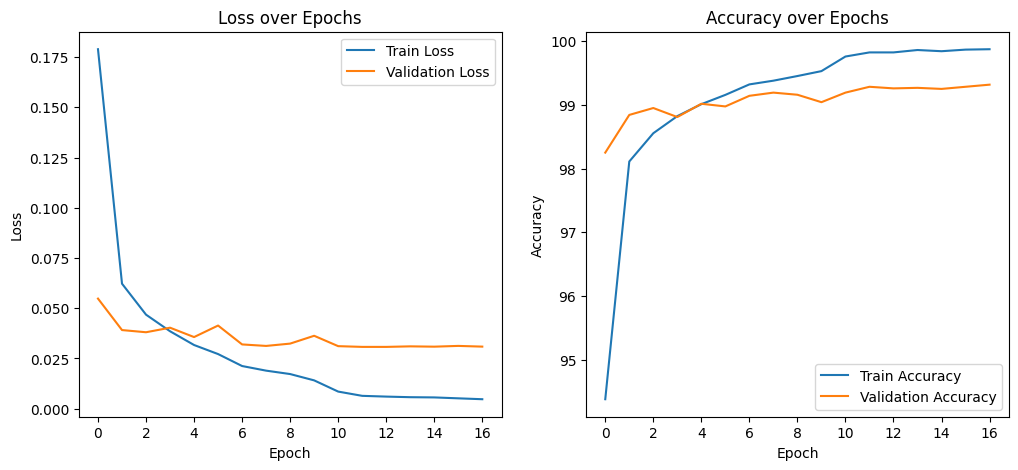

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This code plots training progress:

	•	Left plot: Train vs. Validation Loss over epochs.
	•	Right plot: Train vs. Validation Accuracy over epochs.
	•	Helps visualize model performance and convergence during training.

## Visualize Misclassified Images

This helps us understand where the model struggles
We’ll display a few misclassified examples from the test set.

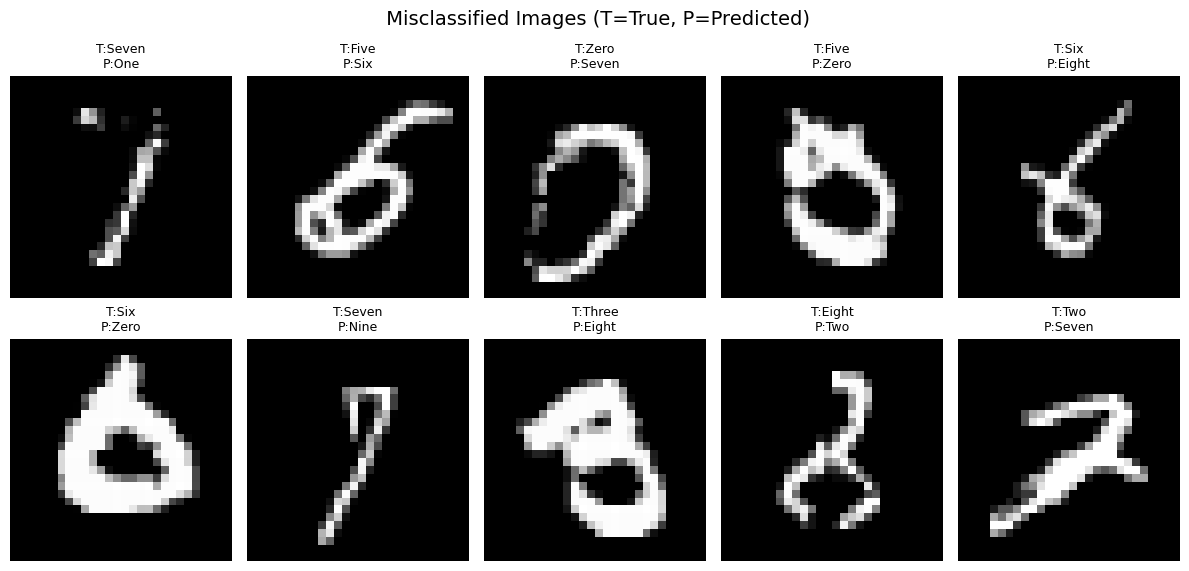

In [11]:
import random

# Get class names for Fashion MNIST
classes = [
    "Zero", "One", "Two", "Three", "Four",
    "Five", "Six", "Seven", "Eight", "Nine"
]

# Collect some misclassified examples
misclassified_images = []
misclassified_labels = []
misclassified_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        mismatches = preds != labels
        for i in range(len(labels)):
            if mismatches[i]:
                misclassified_images.append(images[i].cpu())
                misclassified_labels.append(labels[i].cpu())
                misclassified_preds.append(preds[i].cpu())

# Show 10 random misclassified samples
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random.sample(range(len(misclassified_images)), 10)):
    plt.subplot(2, 5, i+1)
    plt.imshow(misclassified_images[idx].squeeze(), cmap='gray')
    plt.title(f"T:{classes[misclassified_labels[idx]]}\nP:{classes[misclassified_preds[idx]]}", fontsize=9)
    plt.axis('off')
plt.suptitle(" Misclassified Images (T=True, P=Predicted)", fontsize=14)
plt.tight_layout()
plt.show()

This code visualizes misclassified test images:

	•	Compares the model’s predictions with true labels.
	•	Collects all misclassified examples.
	•	Displays 10 random misclassified images with their true (T) and predicted (P) labels.

## Confusion Matrix

A confusion matrix shows how predictions are distributed across all classes —
revealing systematic errors.


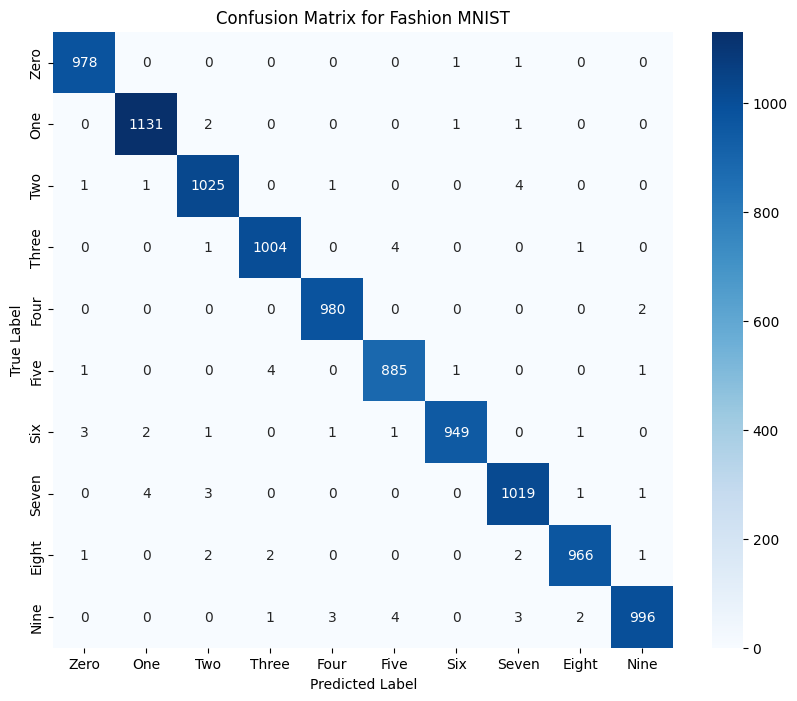

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Fashion MNIST")
plt.show()

This code computes and visualizes the confusion matrix for the test set:

	•	Compares true labels vs. model predictions.
	•	Uses Seaborn heatmap to show correct and incorrect predictions per class.
	•	Helps analyze which classes are often misclassified.


## Per-Class Accuracy

Let’s compute accuracy for each class individually — to see which types of items our model classifies most accurately.

/tmp/ipython-input-2837725663.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=accs, palette="viridis")


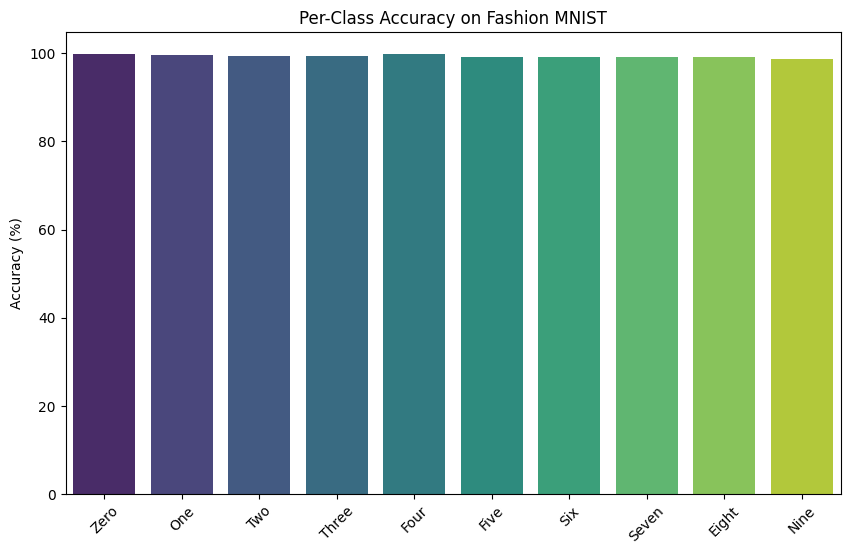

Zero           : 99.80%
One            : 99.65%
Two            : 99.32%
Three          : 99.41%
Four           : 99.80%
Five           : 99.22%
Six            : 99.06%
Seven          : 99.12%
Eight          : 99.18%
Nine           : 98.71%


In [13]:
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (preds[i] == label).item()
            class_total[label] += 1

plt.figure(figsize=(10,6))
accs = [100 * c / t for c, t in zip(class_correct, class_total)]
sns.barplot(x=classes, y=accs, palette="viridis")
plt.xticks(rotation=45)
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy on Fashion MNIST")
plt.show()

for i, acc in enumerate(accs):
    print(f"{classes[i]:15s}: {acc:.2f}%")

## Visualize CNN Feature Maps

Let’s peek inside our CNN to see what the first convolutional layer is learning —
these filters often capture edges, textures, and simple shapes.

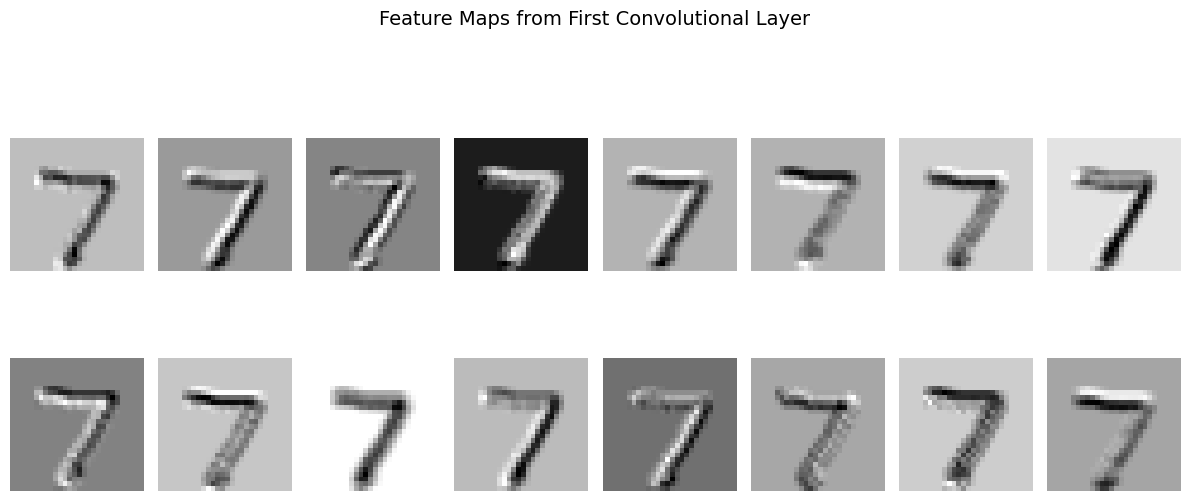

In [14]:
# Take one sample image
image = test_images[0].unsqueeze(0).to(device)

# Get feature maps from the first convolutional layer
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(image).cpu()

# Visualize
plt.figure(figsize=(12, 6))
for i in range(16):
    plt.subplot(2, 8, i+1)
    plt.imshow(feature_maps[0, i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Feature Maps from First Convolutional Layer", fontsize=14)
plt.tight_layout()
plt.show()

## Comprehensive Analysis of the Notebook

This notebook provides a complete and well-structured workflow for building, training, and evaluating a Convolutional Neural Network (CNN) for image classification on the Fashion-MNIST dataset. The analysis below integrates the findings from various parts of the notebook to provide a holistic view of the process and results.

**Data Loading and Preparation:** The initial steps of loading the IDX formatted data, creating a custom PyTorch Dataset, and setting up DataLoaders are crucial and were executed successfully. The confirmation of dataset shapes and the appropriate split into training, validation, and test sets (48000, 12000, and 10000 samples respectively) demonstrate proper data handling. The normalization and standardization applied during dataset creation are standard and effective preprocessing steps for image data, ensuring that the model receives inputs within a suitable range.

**Model Architecture and Training Setup:** The defined `FashionCNN` model is a reasonable architecture for this task, incorporating common and effective layers like convolutional layers, batch normalization, pooling, and dropout. The choice of `CrossEntropyLoss` is appropriate for multi-class classification, and the `SGD` optimizer with momentum is a solid choice. The use of a `StepLR` scheduler allows for dynamic adjustment of the learning rate during training, which can help in converging to a better minimum. Setting the device to 'cuda' when available ensures that training leverages GPU acceleration, significantly speeding up the process. The implementation of `EarlyStopping` is a critical component for preventing overfitting, as it monitors the validation loss and halts training when improvement plateaus.

**Training and Evaluation:** The training loop effectively utilizes the DataLoaders, loss function, optimizer, scheduler, and early stopping mechanism. The reported epoch-wise training and validation losses and accuracies show a clear learning trend, with both losses decreasing and accuracies increasing. The early stopping at epoch 16 indicates that the model had reached a point where further training on the training data was not leading to significant improvement on the unseen validation data, thus preventing overfitting. The final test accuracy of 99.33% is a strong result for the Fashion-MNIST dataset, demonstrating that the trained model generalizes very well to unseen data.

**Performance Analysis and Visualizations:** The post-training analysis through visualizations provides valuable insights beyond just the final accuracy number.

*   **Training Progress Plots:** The loss and accuracy curves visually confirm the learning process and the effectiveness of early stopping. The point where validation loss starts to diverge or plateau from training loss is often an indicator of overfitting, and early stopping helps to mitigate this.
*   **Misclassified Images:** Examining the misclassified images is a qualitative way to understand the model's errors. It can reveal systematic confusions between similar classes (e.g., different types of apparel) and highlight areas where the model might struggle due to subtle visual variations or ambiguities in the dataset.
*   **Confusion Matrix:** The confusion matrix provides a quantitative breakdown of classification performance across all classes. It clearly shows which classes are most often confused with each other, complementing the insights from misclassified images. High values on the diagonal and low values off the diagonal are indicative of good performance.
*   **Per-Class Accuracy:** The per-class accuracy further refines the performance analysis by showing how accurate the model is for each individual class. This helps identify classes that are particularly challenging for the model and might require more attention in terms of data or model improvements.

**Feature Map Visualization:** While not directly a performance metric, visualizing the feature maps from the first convolutional layer provides a glimpse into what the network is learning at its initial stages. Seeing the filters respond to basic shapes and edges confirms that the convolutional layers are performing their intended function of extracting hierarchical features from the input images.

**Overall Assessment:** The notebook demonstrates a robust approach to image classification. The code is well-structured, utilizing PyTorch's features effectively. The inclusion of validation, early stopping, and various analysis techniques makes the training process more reliable and provides a thorough understanding of the model's performance. The high test accuracy achieved indicates that the model is well-suited for the Fashion-MNIST task. Potential next steps could involve exploring more complex architectures, advanced data augmentation techniques, or analyzing the misclassifications in more detail to identify root causes and potential solutions.

## Visualizing what the CNN learns — Filters, Feature Maps, and Activation Maximisation

This section gives you code and explanations to:

	•	Inspect learned convolutional filters (weights) directly.
	•	Visualize feature maps produced when a real test image passes through the network.
	•	Synthesize ideal inputs that maximize a chosen filter’s activation (activation maximization / input optimization).

These techniques help build intuition about low-level edge detectors, mid-level texture detectors, and higher-level pattern detectors in convolutional networks.

In [15]:
# Ensure basic environment & variables exist: model, device, test_dataset/test_loader, test_images tensor
import torch, numpy as np, matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# If model or device not defined, raise an informative error.
try:
    _ = model
    _ = device
except NameError:
    raise RuntimeError("`model` or `device` is not defined. Load or train your FashionCNN and set `device` (cuda/cpu) before running these cells.")

### 1. Utilities: normalisation and plotting helpers

We’ll need small utilities to normalize filter weights and to plot a grid of images.

In [16]:
from math import ceil
import matplotlib.pyplot as plt

def normalize_tensor(x):
    """Normalize a tensor to 0..1 for visualization (works on numpy or torch)."""
    x_min = x.min()
    x_max = x.max()
    if x_max - x_min == 0:
        return np.clip(x, 0, 1)
    return (x - x_min) / (x_max - x_min)

def plot_grid(images, n_cols=8, cmap='gray', figsize=(12,6), titles=None):
    """
    Plot a list/array of images in a grid.
    images: array-like of shape (N, H, W) or (N, H, W, C)
    """
    n_images = len(images)
    n_cols = min(n_cols, n_images)
    n_rows = ceil(n_images / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).reshape(-1)
    for i, ax in enumerate(axes):
        ax.axis('off')
        if i < n_images:
            im = images[i]
            if isinstance(im, torch.Tensor):
                im = im.cpu().numpy()
            if im.ndim == 3 and im.shape[0] in (1,3):  # CHW -> HWC
                im = np.transpose(im, (1,2,0))
            ax.imshow(im.squeeze(), cmap=cmap)
            if titles is not None and i < len(titles):
                ax.set_title(titles[i], fontsize=8)
    plt.tight_layout()
    plt.show()

### 2. Visualise learned convolutional filters (weights)

We’ll visualize the weights of the first few convolutional layers. For grayscale input, kernels are single-channel; for deeper layers they can be multi-channel — we show each filter’s effective 2D pattern by either plotting the single-channel kernel (conv1) or combining across input channels (e.g., by summing or PCA) for deeper layers.

**Interpretation tip:** In the first conv layer you should see edge detectors and Gabor-like patterns. Deeper layers show more complex patterns / textures.

Visualizing conv1 filters


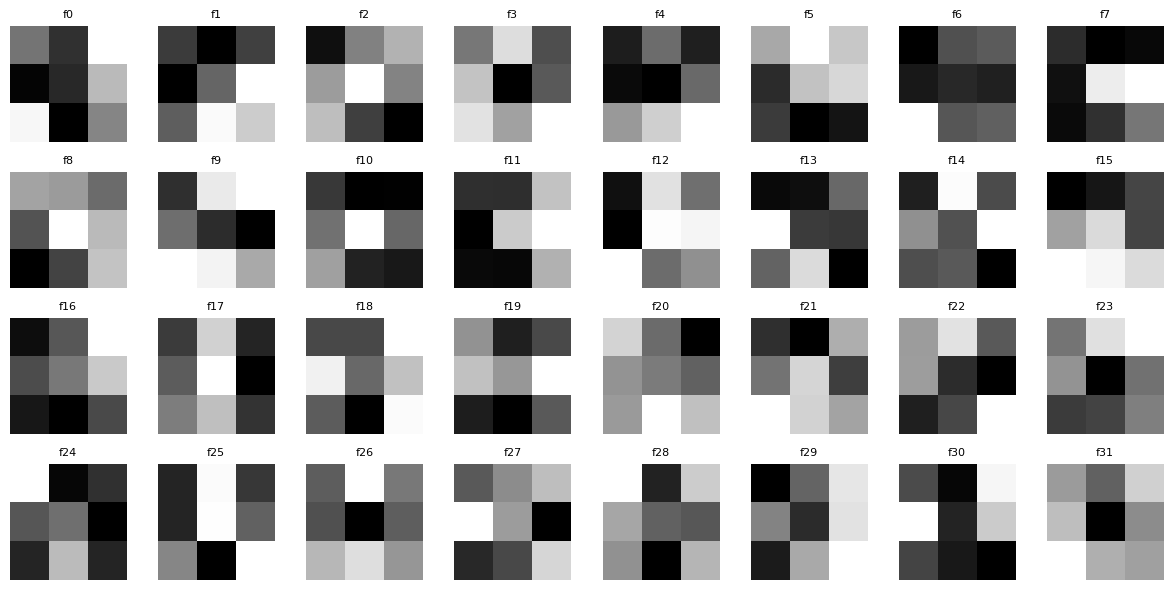

Visualizing conv2 filter summary (mean across input channels)


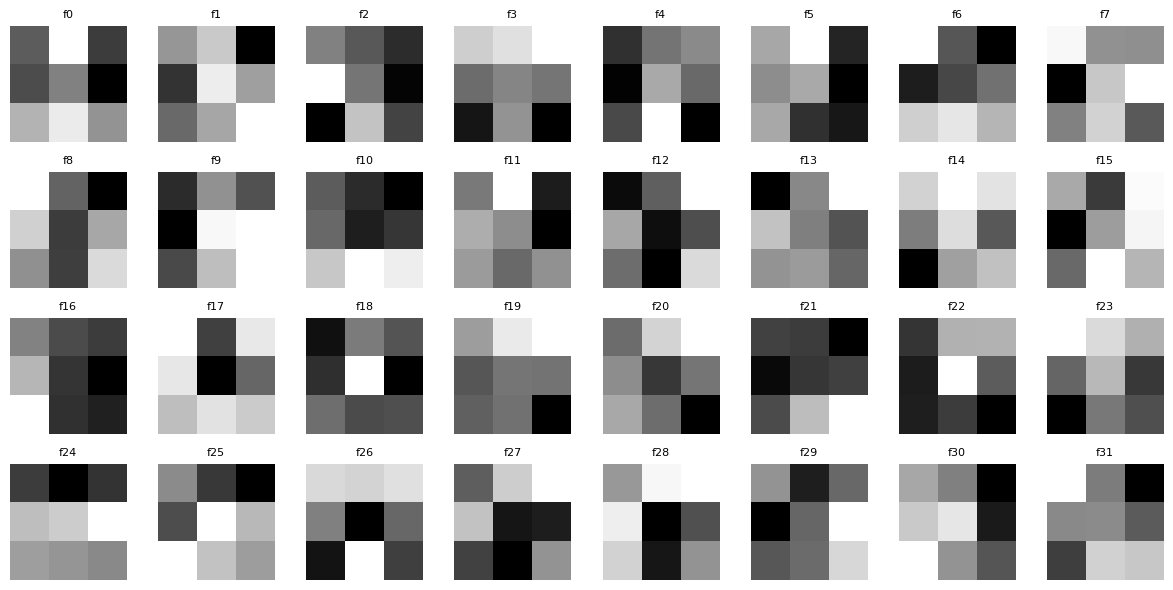

In [17]:
import torch

def visualize_conv_weights(layer, n_filters=32, combine_mode='sum', n_cols=8):
    """
    Visualize convolutional kernels for a given conv layer.
    - layer: nn.Conv2d layer from the model (e.g., model.conv1)
    - n_filters: how many output filters to show (start from filter 0)
    - combine_mode: how to convert multi-channel kernels to 2D image: 'sum', 'mean', or 'first'
    """
    weights = layer.weight.data.clone().cpu()  # shape: (out_channels, in_channels, kH, kW)
    out_ch, in_ch, kH, kW = weights.shape
    n_filters = min(n_filters, out_ch)
    imgs = []
    titles = []
    for i in range(n_filters):
        kernel = weights[i]  # (in_ch, kH, kW)
        if in_ch == 1:
            im = kernel[0].numpy()
        else:
            if combine_mode == 'sum':
                im = kernel.sum(dim=0).numpy()
            elif combine_mode == 'mean':
                im = kernel.mean(dim=0).numpy()
            elif combine_mode == 'first':
                im = kernel[0].numpy()
            else:
                # fallback to mean
                im = kernel.mean(dim=0).numpy()
        im = normalize_tensor(im)
        imgs.append(im)
        titles.append(f"f{i}")
    plot_grid(imgs, n_cols=n_cols, titles=titles, cmap='gray', figsize=(12, (len(imgs)/n_cols)*1.5))

# Example: visualize conv1 filters (usually most interpretable)
print("Visualizing conv1 filters")
visualize_conv_weights(model.conv1, n_filters=32, combine_mode='first', n_cols=8)

# If you have conv2:
if hasattr(model, 'conv2'):
    print("Visualizing conv2 filter summary (mean across input channels)")
    visualize_conv_weights(model.conv2, n_filters=32, combine_mode='mean', n_cols=8)

	•	model.conv1 filters often look like edge detectors (oriented lines), spots, or checker patterns.
	•	conv2 and deeper layers are combinations of earlier features — we visualize them by averaging/summing across input channels to get a 2D depiction.
	•	If you see random noise instead of structured patterns, the model might not be trained enough.

### 3. Visualise Feature Maps (activations) for a given input image

We’ll extract activations for several layers (conv1, conv2, etc.) using forward hooks or manual forward passes, then visualize the activation maps.

Why: Feature maps show where the network “looks” (which spatial locations are strongly activated) after each convolutional stage.

Feature maps after conv1 — showing 32/32


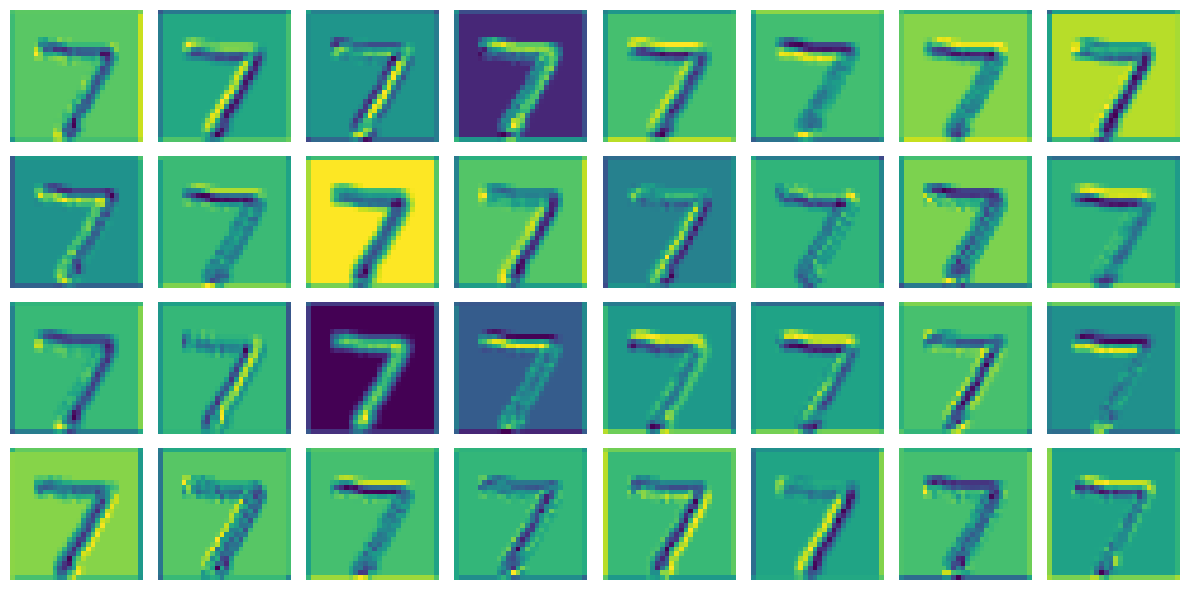

Feature maps after conv2 — showing 32/64


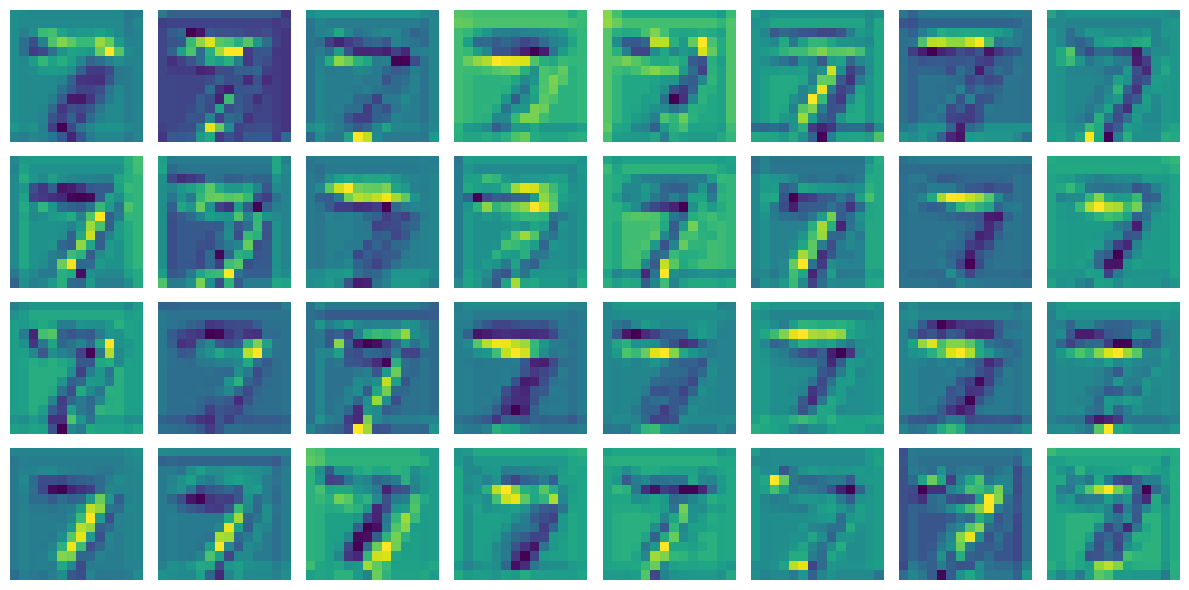

In [18]:
# Utility to fetch activations using hooks
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for the layers you want
layer_names = []
if hasattr(model, 'conv1'):
    model.conv1.register_forward_hook(get_activation('conv1'))
    layer_names.append('conv1')
if hasattr(model, 'conv2'):
    model.conv2.register_forward_hook(get_activation('conv2'))
    layer_names.append('conv2')
# Add more layers if present: conv3, etc.

# Pick a test image (index 0) and run forward pass
model.eval()
sample_idx = 0
# If you have test_dataset (custom) or test_loader, fetch sample image
try:
    # from our earlier custom dataset: test_dataset exists
    sample_img, sample_label = test_dataset[sample_idx]
    # Ensure tensor shape is (1, H, W) or (C,H,W)
    img = sample_img.unsqueeze(0).to(device)  # add batch dim
except Exception as e:
    # fallback: get one batch from test_loader
    batch = next(iter(test_loader))
    img, sample_label = batch[0][0].unsqueeze(0), batch[1][0]
    img = img.to(device)

# Forward pass (hooks populate `activations`)
with torch.no_grad():
    _ = model(img)

# Plot activation maps
for name in layer_names:
    act = activations[name].cpu().squeeze(0)  # shape: (C, H, W)
    n_maps = act.shape[0]
    n_show = min(32, n_maps)
    imgs = [normalize_tensor(act[i].numpy()) for i in range(n_show)]
    print(f"Feature maps after {name} — showing {n_show}/{n_maps}")
    plot_grid(imgs, n_cols=8, cmap='viridis', figsize=(12, (n_show/8)*1.5))

**Interpretation**

	•	Early layer activations highlight edges and local contrast regions.
	•	Later layer activations respond to more abstract patterns (combinations of edges).
	•	If activations are all near-zero or identical, check for dead ReLUs or learning issues.

### 4. Activation Maximization (synthesize an input that strongly activates a filter)

This is a more advanced technique: start with random noise and iteratively update the input image via gradient ascent to maximize the mean activation of a target filter. Use regularization (L2 + total variation) to keep the image interpretable.

Caveat: This code performs gradient ascent on the input; it can be slower but gives strong intuition about what patterns a filter prefers.

Synthesizing input for conv1 filter 0 (this may take a moment)...
Synthesizing input for conv1 filter 5...


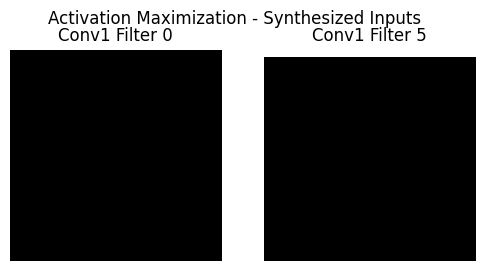

In [20]:
def activation_maximization(model, layer, filter_idx, steps=100, lr=0.1):
    """
    Synthesizes an input image that maximally activates a given filter.
    """
    model.eval()

    # Start with a random image (leaf tensor)
    input_img = torch.randn((1, 1, 28, 28), device=device, requires_grad=True)

    optimizer = torch.optim.Adam([input_img], lr=lr)

    for step in range(steps):
        optimizer.zero_grad()

        # Forward pass only until the target layer
        x = input_img
        for name, module in model._modules.items():
            x = module(x)
            if module == layer:
                break

        # Compute mean activation of the target filter
        activation = x[0, filter_idx]
        loss = -activation.mean()  # negative because we maximize

        loss.backward()
        optimizer.step()

        # Normalize the image occasionally for stability
        with torch.no_grad():
            input_img.clamp_(0, 1)

    return input_img.detach().cpu()

# Example usage for two filters
print("Synthesizing input for conv1 filter 0 (this may take a moment)...")
synth1 = activation_maximization(model, model.conv1, filter_idx=0, steps=200, lr=0.1)

print("Synthesizing input for conv1 filter 5...")
synth2 = activation_maximization(model, model.conv1, filter_idx=5, steps=200, lr=0.1)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(synth1.squeeze(), cmap='gray')
axs[0].set_title("Conv1 Filter 0")
axs[0].axis('off')
axs[1].imshow(synth2.squeeze(), cmap='gray')
axs[1].set_title("Conv1 Filter 5")
axs[1].axis('off')
plt.suptitle("Activation Maximization - Synthesized Inputs")
plt.show()

Interpretation of activation maximisation results

	•	For conv1, synthesized images should show oriented edges or Gabor-like patterns — confirming low-level detectors.
	•	For conv2+, synthesized images are typically more complex textures or combinations of edges.
	•	If the synth result is noisy or doesn’t show structure, try increasing steps, tuning lr, or increasing regularization.

### 5. Visualizing filters using PCA (combine multi-channel kernels)

For conv layers with multiple input channels, you can project each multi-channel kernel to 2D using PCA to visualize principal components across channels.

PCA projection visualization for conv2 kernels


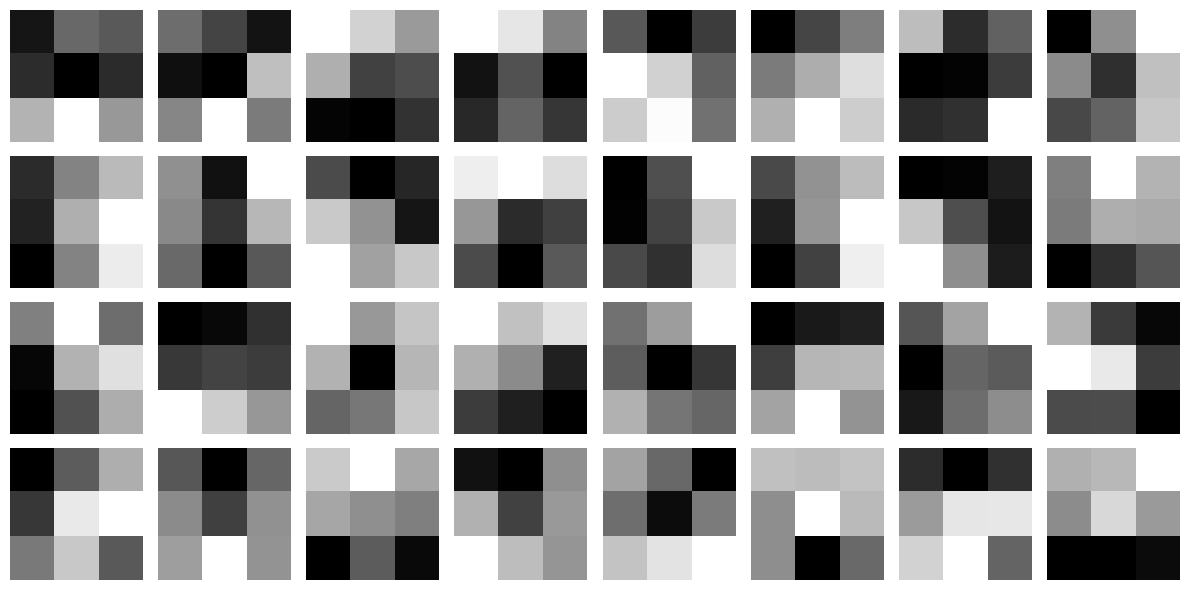

In [21]:
from sklearn.decomposition import PCA

def visualize_conv_weights_pca(layer, n_filters=32, n_cols=8):
    weights = layer.weight.data.clone().cpu().numpy()  # (out_ch, in_ch, kH, kW)
    out_ch, in_ch, kH, kW = weights.shape
    n_filters = min(n_filters, out_ch)
    imgs = []
    for i in range(n_filters):
        kernel = weights[i].reshape(in_ch, -1)  # (in_ch, kH*kW)
        pca = PCA(n_components=1)
        proj = pca.fit_transform(kernel.T).reshape(kH, kW)  # project to 2D
        imgs.append(normalize_tensor(proj))
    plot_grid(imgs, n_cols=n_cols, cmap='gray', figsize=(12, (len(imgs)/n_cols)*1.5))

if hasattr(model, 'conv2'):
    print("PCA projection visualization for conv2 kernels")
    visualize_conv_weights_pca(model.conv2, n_filters=32, n_cols=8)

#### The Visualisation illustrates what the kernels (filters) in the second convolutional layer (conv2) have learned to detect. In a CNN trained on images like those in MNIST (grayscale digits):

**Learned Feature Detectors (Filters):** Each small grid (kernel) is a visual representation of a feature the conv2 layer is looking for. These are not random patterns; they are the result of the network's training process on the MNIST images.

**Building Blocks of Digits:** The filters in the first convolutional layer (conv1) typically learn to detect very simple, low-level features, such as basic edges (horizontal, vertical, diagonal) and corners. The kernels in the second layer (conv2) take the output of conv1 and combine these simple features to form more complex, mid-level patterns.

**Visualisation of Principal Components:** Since a conv2 kernel has multiple input channels (one for each filter in the conv1 output), it's a high-dimensional object. Principal Component Analysis (PCA) is used here as a dimensionality reduction technique to compress the multi-channel weights into a single 2D image for visualization. The resulting grayscale images (the kernels you see) represent the principal components of the filter weights across its input channels, highlighting the core spatial patterns it's responsible for recognizing.

## Analysis and Summary of Visualising CNN Learnings

This section of the notebook delves into understanding the internal workings of the trained CNN by visualizing its learned components and responses.

### Analysis

**Visualising Learned Convolutional Filters (Weights):** The visualisation of convolutional filters provides a direct look at the patterns that the initial layers of the network are designed to detect.
*   For `conv1`, which operates directly on the input image, the filters often resemble basic edge detectors (horizontal, vertical, diagonal), corners, or simple blob-like structures. This confirms the expectation that the first layer learns low-level visual features. The `combine_mode` parameter is useful here to represent multi-channel kernels in later layers as a 2D image, though some information is lost in this process.
*   The visualisation of `conv2` filters (if present) shows more complex patterns, which are combinations of the features learned in `conv1`. This demonstrates the hierarchical nature of CNNs, where deeper layers learn more abstract and complex representations.

**Visualising Feature Maps (Activations):** Visualising feature maps shows the output of convolutional layers for a given input image. These maps highlight regions in the image that strongly activate a particular filter.
*   For early layers like `conv1`, the feature maps show where the detected edges or simple patterns are located in the input image. Different feature maps highlight different types of edges or patterns.
*   For later layers like `conv2`, the feature maps show responses to more complex combinations of features. These might correspond to parts of objects or textures. The spatial dimensions of the feature maps decrease due to pooling, indicating downsampling and the focus on higher-level features.
*   The intensity in the feature maps indicates the strength of the activation, showing which parts of the input image are most relevant to a particular filter.

**Activation Maximisation:** Activation maximisation is a technique to synthesize an input image that maximally activates a specific filter. This provides insight into what kind of input pattern a filter is "looking for."
*   For `conv1` filters, the synthesised images often show clear, simple patterns like oriented lines or textures, consistent with the filter visualisations. This reinforces the understanding of the first layer as learning basic visual primitives.
*   For filters in deeper layers, the synthesised images become more complex and abstract, representing combinations of features from earlier layers. This technique helps to interpret the learned representations in deeper parts of the network, although the resulting images can sometimes be challenging to interpret visually.

**Visualising filters using PCA:** Using PCA to visualize multi-channel kernels is another way to get a 2D representation of what a filter in deeper layers is learning. By projecting the multi-channel kernel onto its principal component, we can see the dominant pattern across all input channels for that filter. This can sometimes provide a clearer visualization than simple summation or averaging.

### Summary

This section effectively utilises visualisation techniques to gain a deeper understanding of how the trained CNN works internally. By visualizing the learned filters, feature maps, and using activation maximization, we can observe the hierarchical nature of feature learning in CNNs, starting from simple edge detectors in the first layer and progressing to more complex pattern detectors in deeper layers. These visualisations provide valuable intuition about what the network has learned and how it processes information to perform image classification. They serve as a powerful tool for debugging, interpreting, and potentially improving the model.